In [12]:
import os

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [14]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)

<module 'gamma_SSN_losses' from '/home/cholt/Python/torch_SSN/jax_caleb/gamma_SSN_losses.py'>

In [15]:
os.getpid()

25551

In [19]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

In [20]:
def ssn_PS(params, contrasts):
    #unpack parameters
    Jee = params[0]
    Jei = params[1]
    Jie = params[2]
    Jii = params[3]
    i2e = params[4]
    
    cons = len(contrasts)

    J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[1], [i2e]]) * contrasts
    
    r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, r_fp


#@jit
def loss(params):
    contrasts = np.array([0, 25, 50, 100])
    spect, fs, r_fp = ssn_PS(params, contrasts)
    
    if np.max(np.abs(np.imag(spect))) > 0.01:
        print("Spectrum is dangerously imaginary")
    
    spect_loss = losses.loss_spect_contrasts(fs, np.real(spect))
    rates_loss = losses.loss_rates_contrasts(r_fp)
    
#     print(spect_loss/rates_loss)
    
    return spect_loss + rates_loss
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))
        
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))




# def ssn_PS_v(params, contrasts):
#     #unpack parameters
#     Jee = params[0]
#     Jei = params[1]
#     Jie = params[2]
#     Jii = params[3]
#     i2e = params[4]

#     J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
#     ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
#     spect = []
#     v_init = np.zeros(ssn.dim)
#     for con in contrasts:
#         inp_vec = np.array([1,i2e]) * con
#         v_fp = ssn.fixed_point(inp_vec, x_init=v_init, Tmax=Tmax, dt=dt, xtol=xtol)
#         v_init = v_fp
#         r_fp = ssn.powlaw( v_fp.reshape((ssn.num_rcpt, ssn.N)).sum(axis=0) )

#         powspecE, fs, _ = SSN_power_spec.linear_power_spect(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range=freq_range, fnums=fnums)
#         spect.append(powspecE)
    
#     spect = np.array(spect).T
#     return spect, fs

run time: 1.4049582481384277


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'frequency (Hz)')

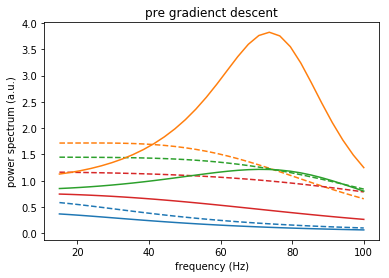

In [21]:
params_init = np.array([2.5, 1.3, 2.4,  1.0, 1.0]) # [Jee, Jei, Jie, Jii, i2e]
test_contrasts = np.array([0, 25, 50, 100])

import time
t0 = time.time()
spect, fs, r_fp = ssn_PS(params_init, test_contrasts)
tt = time.time()-t0
print("run time:", tt)

target_PS = losses.get_target_spect(fs)


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

# Run Gradient Descent

In [36]:
#dloss = grad(loss)
dloss = value_and_grad(loss)

gd_iters = 1000
eta = .005 #learning rate

params = params_init
loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    if ii % 100 == 0:
        print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

G.D. step  1


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


G.D. step  101
G.D. step  201
G.D. step  301
G.D. step  401
G.D. step  501
G.D. step  601
G.D. step  701
G.D. step  801
G.D. step  901
1000 GD steps took 5376.081614971161 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [1.8697317 0.8559016 2.6357646 1.0696018 1.3677385]


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'frequency (Hz)')

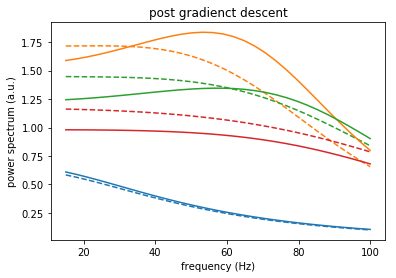

In [37]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

In [49]:
print(losses.loss_rates_contrasts(r_fp))
print(losses.loss_spect_contrasts(fs, np.real(spect)))

0.0042927116
0.00092068


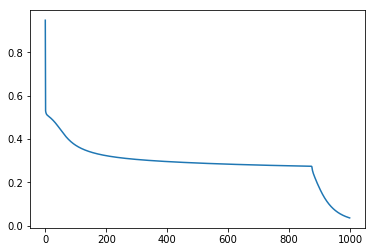

In [39]:
plt.plot(loss_t[:])

In [40]:
#dloss = grad(loss)
# dloss = value_and_grad(loss)

gd_iters = 1000
eta = .005 #learning rate

# params = params_init
# loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    if ii % 100 == 0:
        print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)

G.D. step  1


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


G.D. step  101
G.D. step  201
G.D. step  301
G.D. step  901
1000 GD steps took 4656.45205450058 seconds.
fit [Jee, Jei, Jie, Jii, i2e] =  [1.7986668 0.9757666 2.587415  1.2968954 1.3878803]


/home/cholt/miniconda3/envs/juC/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'G.D. Step')

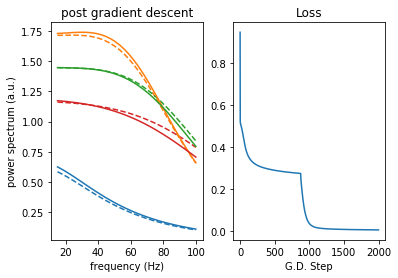

In [45]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, [ax, ax2] = plt.subplots(1,2)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradient descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

ax2.plot(loss_t[:])
ax2.set_title('Loss')
ax2.set_xlabel('G.D. Step')


In [46]:
params

DeviceArray([1.79866683, 0.9757666, 2.58741498, 1.29689538, 1.38788033],
            dtype=float32)

In [47]:
params - np.array([1.7, 1.25, 2.2,  1.5, 1.2])

DeviceArray([ 0.09866679, -0.2742334 ,  0.38741493, -0.20310462,
              0.18788028], dtype=float32)

In [48]:
r_fp

DeviceArray([[ 0.      ,  5.64452887,  9.90275574, 15.55513382],
             [ 0.      , 15.93474293, 32.69595718, 62.50870514]],
            dtype=float32)

In [54]:
import scipy.io as sio

data = {
    'params_final':params,
    'params_init':params_init,
    'spect_final':spect,
    'rfp_final':r_fp,
    'loss_t':loss_t,
    'ideal_fname':'standJ19-09-20-BestSpect.mat'
}
sio.savemat("groundTruth_Conv_2019-09-26.mat", data)